In [1]:
import warnings
import os
from glob import glob

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn import preprocessing

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [2]:
class CustomDataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y
        
  def __getitem__(self, index):
    return self.X[index], self.y[index]
    
  def __len__(self):
    return len(self.X)

In [3]:
class LSTM(nn.Module):
  def __init__(self, num_classes, num_layers, input_size, hidden_size, device):
    super().__init__()
    self.num_classes = num_classes
    self.num_layer = num_layers
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.device = device
    
    self.lstm = nn.LSTM(
      input_size=input_size,
      hidden_size=hidden_size,
      num_layers=num_layers,
      batch_first=True,
      dropout=0.2)
    self.fc_1 = nn.Linear(hidden_size, 128)
    self.fc_2 = nn.Linear(128, num_classes)
    self.relu = nn.ReLU(inplace=True)
    
  def forward(self, x):
    h_0 = torch.zeros(self.num_layer, x.size(0), self.hidden_size, device=self.device)
    c_0 = torch.zeros(self.num_layer, x.size(0), self.hidden_size, device=self.device)
    
    output, (hn, cn) = self.lstm(x, (h_0, c_0))
    # hn : numlayer batchsize hiddensize
    out = hn.view(-1, self.hidden_size)
    out = self.relu(out)
    out = self.fc_1(out)
    out = self.relu(out)
    out = self.fc_2(out)
    return out

In [17]:
class Trainer:
  def __init__(self, path):
    self.path = path
    self.n_step_in = 24 * 2
    self.n_step_out = 24 * 3
    
    self.n_epochs = 100
    self.lr = 0.001
    self.input_size = 6
    self.hidden_size = 8
    self.num_layers = 1
    self.num_classes = 24*3
    
    self.device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    
  def set_up(self):
    csv_list = os.listdir(self.path)
    X_train, X_val, y_train, y_val = [], [], [], []
    for csv_name in csv_list:
      df = pd.read_csv(self.path+str(csv_name))
      df.drop(columns=["연도", "일시", "측정소"], inplace=True)

      scaler = preprocessing.MinMaxScaler()
      scaled_np = scaler.fit_transform(df.values)
      scaled_df = pd.DataFrame(scaled_np, columns=df.columns)
      X_tmp, y_tmp = self._split_sequences(
        input_seq=scaled_df.values,
        output_seq=scaled_df["PM2.5"].values,
        n_step_in=self.n_step_in,
        n_step_out=self.n_step_out)
      X_train_tmp = X_tmp[:-200]
      X_val_tmp = X_tmp[-200:]
      
      y_train_tmp = y_tmp[:-200]
      y_val_tmp = y_tmp[-200:]
      
      X_train.append(X_train_tmp)
      X_val.append(X_val_tmp)
      y_train.append(y_train_tmp)
      y_val.append(y_val_tmp)
    X_train = np.concatenate(X_train, axis=0)
    X_val = np.concatenate(X_val, axis=0)
    y_train = np.concatenate(y_train, axis=0)
    y_val = np.concatenate(y_val, axis=0)
    
      
    train_dataset = CustomDataset(X_train, y_train)
    val_dataset = CustomDataset(X_val, y_val)

    self.train_dataloader = DataLoader(
      dataset=train_dataset,
      shuffle=True,
      batch_size=256,
    )
    
    self.val_dataloader = DataLoader(
      dataset=val_dataset,
      shuffle=False,
      batch_size=256,
      drop_last=True
    )
    
  def _split_sequences(self, input_seq, output_seq, n_step_in, n_step_out):
    X, y = list(), list()
    for i in range(0, len(input_seq), 24):
      end_idx = i + n_step_in
      out_end_idx = end_idx + n_step_out
      if out_end_idx > len(input_seq):
        break
      seq_x, seq_y = input_seq[i:end_idx], output_seq[end_idx:out_end_idx]
      X.append(seq_x)
      y.append(seq_y)
    return np.array(X), np.array(y)
  

  def train(self):
    model = LSTM(
      num_classes=self.num_classes,
      num_layers=self.num_layers,
      input_size=self.input_size,
      hidden_size=self.hidden_size,
      device=self.device).to(self.device)
    
    loss_fn = nn.MSELoss().to(self.device)
    optimizer = optim.Adam(model.parameters(), lr=self.lr)
    
    print("TRAIN START")
    for epoch in range(1, self.n_epochs+1):
      model.train()
      train_loss = []
      for batch in self.train_dataloader:
        X, y = batch
        X = X.float().to(self.device)
        y = y.float().to(self.device)
        outputs = model.forward(X)
        optimizer.zero_grad()
        loss = loss_fn(outputs, y)
        train_loss.append(loss.item())
        loss.backward()
        optimizer.step()
      
      model.eval()
      with torch.no_grad():
        val_loss = []
        for batch in self.val_dataloader:
          X, y = batch
          # numpy 기본 자료형은 float64이므로 float32에 매칭시켜줘야함
          X = X.float().to(self.device)
          y = y.float().to(self.device)
          outputs = model.forward(X)
          loss = loss_fn(outputs, y)
          val_loss.append(loss.item())
      
      
      if epoch % 10 == 0:
        # 데이터에 nan값이 있는 경우 loss가 계속 nan값이 나옴
        print(f"Epoch: {epoch},\
          train loss: {sum(train_loss)/len(train_loss):.5f},\
          val loss: {sum(val_loss)/len(val_loss):.5f}")
        
    print("TRAIN FIN")

    return model
  
      
  def plot(self, model, idx):
    model.eval()
    with torch.no_grad():
      X, y = next(iter(self.val_dataloader))
      X = X.float().to(self.device)
      y = y.float().to(self.device)
      output = model.forward(X)
    y = y.cpu().numpy()
    output = output.cpu().numpy()
    plt.plot(output[idx], color='b')
    plt.plot(y[idx], color='g')
    plt.show()

In [18]:
trainer = Trainer(path='./dataset/CUSTOM_v1/')
trainer.set_up()

In [6]:
mdl = trainer.train()
torch.save(mdl, "lstm_v1.pth")

c:\Users\BSH\.virtualenvs\aifactory-cLCMmIYn\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


TRAIN START
Epoch: 10,          train loss: 0.00587,          val loss: 0.00410
Epoch: 20,          train loss: 0.00578,          val loss: 0.00420
Epoch: 30,          train loss: 0.00573,          val loss: 0.00410
Epoch: 40,          train loss: 0.00568,          val loss: 0.00409
Epoch: 50,          train loss: 0.00567,          val loss: 0.00414
Epoch: 60,          train loss: 0.00564,          val loss: 0.00406
Epoch: 70,          train loss: 0.00564,          val loss: 0.00406
Epoch: 80,          train loss: 0.00560,          val loss: 0.00407
Epoch: 90,          train loss: 0.00558,          val loss: 0.00417
Epoch: 100,          train loss: 0.00558,          val loss: 0.00413
TRAIN FIN


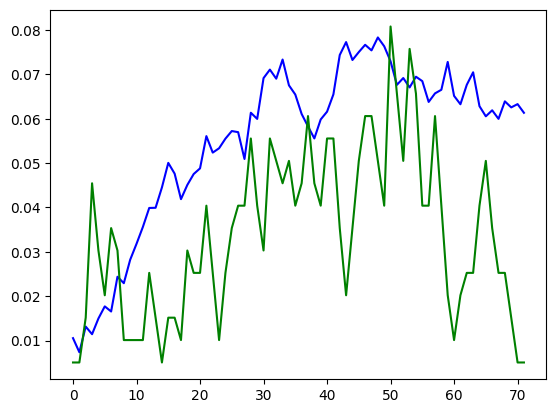

In [20]:
trainer.plot(mdl, 10)